# Projet de modélisation non supervisée des fonctionnalités de prédiction des tags 

## Imports

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
import nltk.data
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import string
from langdetect import detect
import re
import spacy
from spacy.symbols import ORTH, NORM
from langdetect import detect_langs
import langid
from bs4 import BeautifulSoup

import gensim
from gensim import corpora, models
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import tqdm

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from collections import Counter

from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

import pickle

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)


## Import dataset

In [3]:
data = pd.read_csv('./dataset/preprocessed_dataset.csv',sep=",")

In [4]:
data.head()

,body,tags
0,write daemon run emb platform need chang default rout devic accord interfac connect give time programat know use system rout del default rout add default gateway blah etc direct way updat solv particular problem discov patch pppd allow replacedefaultrout option patch also includ code programmat modifi rout tabl includ gentoo bug report,"c,linux,networking"
1,use gdi+ c++ two problem find canvasimg black chang color white mean want white canva draw thing canva clear canva mani thank,"canvas,gdi+"
2,write program need determin bit set know rotat word leav right shift access individu bite state use bitwis oper like xor,"assembly,bit-manipulation,mips"
3,consol applic server accept sever connect client possibl listen event close applic want event tell connect client gentl disconnect applic realli close solut thank,"java,events,listener"
4,attempt provid script solut read content file client machin browser solut work firefox internet explor pretti tri thing moment call write content filecont text area way browser concern safari chrome moment open suggest browser edit respons question want basic want hash file content togeth one time password client side send inform back verif,"javascript,html,file-io,sandbox"


## Modélisation non supervisée

Pour effectuer une modélisation non supervisée nous choisissons d'implémenter un modèle entrainé sur l'algorithme Latent Dirichlet Allocation (LDA par la suite).

L'algorithme a pour objectif d'établir une prédiction des topics relatifs à un ensemble de données textuelles. 

Il s'appuie sur 2 composants essentiels : 

    - Un dictionnaire, qui est l'ensemble des termes du langage
    - Le corpus, qui est l'ensemble des règles caractérisant les termes du langage (description, fréquence, etc, ...)


### Mise en place d'une baseline

On met en place une baseline à partir d'un LDA s'appuyant sur un bag of words simple.

#### Bag of Words

In [5]:
def tokenize(text):
    result = []
    #print(type(text))
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(token)
    return result

processed_body = data['body'].map(tokenize)
processed_body[:10]

dictionary = gensim.corpora.Dictionary(processed_body)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 accord
1 add
2 allow
3 blah
4 bug
5 chang
6 code
7 connect
8 daemon
9 default
10 del


#### Dictionnaire

On crée pour chaque post un dictionnaire qui met en perspective combien de mots il comprend et combien de fois ce mot apparait.

In [6]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_body]

In [6]:
bow_corpus[1]

[(5, 1),
 (27, 1),
 (37, 1),
 (40, 1),
 (41, 3),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 2)]

#### Preview du Bag of Words

In [7]:
bow_show = bow_corpus[10]
for i in range(len(bow_show)):
    print("Word {} (\"{}\") appears {} time.".format(bow_show[i][0], 
                                               dictionary[bow_show[i][0]], 
                                                bow_show[i][1]))

Word 2 ("allow") appears 1 time.
Word 27 ("problem") appears 2 time.
Word 37 ("use") appears 4 time.
Word 38 ("way") appears 4 time.
Word 48 ("mean") appears 1 time.
Word 49 ("thank") appears 1 time.
Word 50 ("thing") appears 1 time.
Word 51 ("want") appears 2 time.
Word 53 ("access") appears 2 time.
Word 60 ("like") appears 3 time.
Word 80 ("realli") appears 1 time.
Word 83 ("solut") appears 1 time.
Word 104 ("pretti") appears 1 time.
Word 106 ("question") appears 1 time.
Word 117 ("work") appears 2 time.
Word 120 ("deriv") appears 5 time.
Word 128 ("implement") appears 3 time.
Word 129 ("list") appears 1 time.
Word 132 ("object") appears 1 time.
Word 135 ("type") appears 11 time.
Word 137 ("actual") appears 1 time.
Word 157 ("class") appears 2 time.
Word 163 ("day") appears 1 time.
Word 186 ("obvious") appears 1 time.
Word 201 ("turn") appears 1 time.
Word 211 ("come") appears 2 time.
Word 220 ("fair") appears 1 time.
Word 225 ("input") appears 1 time.
Word 261 ("abil") appears 1 tim

#### Exécution d'un LDA sur la base du Bag of Words

On définit un nombre de topic à 50 en rapport avec la volumétrie du dataset d'analyse.

In [7]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=50, 
                                       id2word=dictionary, passes=10, workers=7,
                                       random_state=100,chunksize=100,per_word_topics=True)

In [8]:
show = []
for idx, topic in lda_model.print_topics(-1):
    show.append('Topic: {} \nWords: {}'.format(idx, topic))
show[0:5]

['Topic: 0 \nWords: 0.042*"map" + 0.036*"user" + 0.035*"click" + 0.034*"count" + 0.030*"instanc" + 0.029*"menu" + 0.019*"abl" + 0.018*"mous" + 0.016*"use" + 0.016*"replac"',
 'Topic: 1 \nWords: 0.081*"search" + 0.057*"procedur" + 0.042*"store" + 0.031*"result" + 0.020*"status" + 0.018*"use" + 0.017*"txt" + 0.015*"forward" + 0.015*"gui" + 0.014*"execut"',
 'Topic: 2 \nWords: 0.065*"tag" + 0.054*"address" + 0.038*"product" + 0.020*"time" + 0.015*"work" + 0.015*"live" + 0.014*"calcul" + 0.013*"need" + 0.012*"new" + 0.011*"base"',
 'Topic: 3 \nWords: 0.067*"control" + 0.043*"valu" + 0.039*"form" + 0.028*"display" + 0.023*"select" + 0.023*"set" + 0.020*"chang" + 0.020*"edit" + 0.018*"user" + 0.015*"code"',
 'Topic: 4 \nWords: 0.074*"event" + 0.048*"form" + 0.023*"use" + 0.020*"handler" + 0.020*"branch" + 0.018*"submit" + 0.016*"merg" + 0.012*"work" + 0.011*"input" + 0.011*"handl"']

### Mesure des performances

Pour le LDA on mesure les indicateurs de perplexité et de cohérence du modèle 

In [9]:
"""
-----------------------------------------------------------------
Desc:   fonction de calcul de indicateur de performance
        du model
Input:  model
        corpus
        lemmas
        dictionnaire
Output: output console   

Traitements appliqués : 
- n/a 
-----------------------------------------------------------------
"""
def computeLDAPerfIndicators(model, corpus, lemmas, dictionary):
    #Perplexité
    print('\nPerplexity Score: ' + str(model.log_perplexity(corpus)))
    
    # Cohérence
    coherence_model_lda = CoherenceModel(model=model, texts=lemmas, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

In [10]:
computeLDAPerfIndicators(lda_model, bow_corpus, processed_body, dictionary)


Perplexity Score: -10.437418471056018

Coherence Score:  0.4039048022895308


### Amélioration: Feature engineering avec TF-IDF

Création d'un modèle TF-IDF sur bow_corpus

In [11]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.11565658447272077),
 (1, 0.05754279720573613),
 (2, 0.08449939921946943),
 (3, 0.17417548187125143),
 (4, 0.11731433042675461),
 (5, 0.060453178982257834),
 (6, 0.03860108639529847),
 (7, 0.08828895937818372),
 (8, 0.1798532627224299),
 (9, 0.2745013001030148),
 (10, 0.1844212620708418),
 (11, 0.12694560310863812),
 (12, 0.08792191448817356),
 (13, 0.1409138405283942),
 (14, 0.11953868087452152),
 (15, 0.19312919901941702),
 (16, 0.23103663331574822),
 (17, 0.16722631889183848),
 (18, 0.09772712316120548),
 (19, 0.045150802151398724),
 (20, 0.10443565681292098),
 (21, 0.04166015436551212),
 (22, 0.08380066486911258),
 (23, 0.097519179697227),
 (24, 0.31044352944617165),
 (25, 0.12221449203997013),
 (26, 0.24999035046391382),
 (27, 0.050960363661180175),
 (28, 0.15608991490035537),
 (29, 0.13051027319891328),
 (30, 0.10225719679793979),
 (31, 0.5485447910087591),
 (32, 0.05407512882911201),
 (33, 0.10140829919749607),
 (34, 0.06720342802533767),
 (35, 0.05709041924265162),
 (36, 

#### Exécution d'un LDA utilisant notre TF-IDF

In [12]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=50, id2word=dictionary, passes=10, workers=7,
                                       random_state=100,chunksize=100,per_word_topics=True)

In [13]:
show = []
for idx, topic in lda_model_tfidf.print_topics(-1):
    show.append('Topic: {} Word: {}'.format(idx, topic))
show[0:5]

['Topic: 0 Word: 0.028*"drag" + 0.011*"coordin" + 0.007*"cakephp" + 0.003*"birthday" + 0.002*"automag" + 0.002*"pin" + 0.001*"genr" + 0.001*"helper" + 0.000*"cake" + 0.000*"drop"',
 'Topic: 1 Word: 0.046*"servic" + 0.019*"interfac" + 0.017*"wcf" + 0.017*"proxi" + 0.017*"account" + 0.016*"certif" + 0.015*"setup" + 0.013*"domain" + 0.013*"jar" + 0.012*"runtim"',
 'Topic: 2 Word: 0.031*"layout" + 0.020*"cocoa" + 0.012*"worker" + 0.012*"secondari" + 0.011*"appl" + 0.010*"implicit" + 0.010*"sproc" + 0.010*"metric" + 0.006*"exclus" + 0.005*"tableview"',
 'Topic: 3 Word: 0.022*"json" + 0.017*"dictionari" + 0.013*"foreach" + 0.013*"traffic" + 0.011*"slide" + 0.010*"eval" + 0.009*"interrupt" + 0.006*"analyt" + 0.005*"distinct" + 0.005*"prepend"',
 'Topic: 4 Word: 0.038*"express" + 0.028*"webservic" + 0.025*"length" + 0.019*"parser" + 0.016*"cell" + 0.014*"vim" + 0.014*"pictur" + 0.014*"protocol" + 0.013*"equal" + 0.013*"textarea"']

#### Mesure des perfs

In [14]:
computeLDAPerfIndicators(lda_model_tfidf, corpus_tfidf, processed_body, dictionary)


Perplexity Score: -20.246456670825143

Coherence Score:  0.4862191394483353


Le score de cohérence est plus élevé, ce qui ne signifie pas que l'algorithme fonctionne mieux. Il nous faut régler les hyperparamètres pour conduire au mieux l'algorithme probabiliste.

#### Réglage des hyperparamètres

On joue sur les hyperparamètres suivants:

    - nombre de topics
    - alpha: sensibilité à la densité de topics par document
    - beta: sensibilité à la densité de mots par topic 

In [15]:
def compute_coherence_values(corpus, dictionary, lemmas, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                            workers=7,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmas, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [16]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 50
max_topics = 150
step_size = 10
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus_tfidf)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus_tfidf, int(num_of_docs*0.25)), 
               # gensim.utils.ClippedCorpus(corpus_tfidf, int(num_of_docs*0.5)), 
               gensim.utils.ClippedCorpus(corpus_tfidf, int(num_of_docs*0.75)), 
               corpus_tfidf]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# loop to fix hyperparam best value 1 each at a time
if 1 == 1:
    total = len(corpus_sets) * len(topics_range) * len(alpha) * len(beta)
    pbar = tqdm.tqdm(total=total)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=dictionary, 
                                                  lemmas=processed_body,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 600/600 [19:42:31<00:00, 118.25s/it]  


#### Exploitation des résultats

Pour chaque validation set on recherche le nombre optimal de clusters qui est celui pour lequel le score de cohérence atteint son premier maximum. Associé à ce score nous saurons également déterminer 'alpha', 'beta'.

In [17]:
hyperparams_results = pd.read_csv('lda_tuning_results.csv',sep=",")

In [18]:
hyperparams_results.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,50,0.01,0.01,0.457478
1,75% Corpus,50,0.01,0.31,0.389925
2,75% Corpus,50,0.01,0.61,0.391896
3,75% Corpus,50,0.01,0.9099999999999999,0.386902
4,75% Corpus,50,0.01,symmetric,0.442185


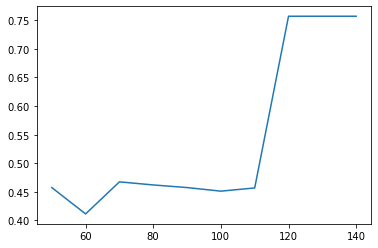

In [51]:
results_75_pc = hyperparams_results[hyperparams_results['Validation_Set' ] == '75% Corpus']
xtract = results_75_pc.query('Alpha == "0.01" and Beta == "0.01"')
plt.plot(xtract['Topics'],xtract['Coherence'])

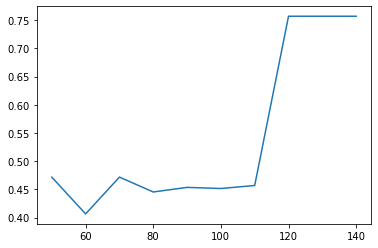

In [52]:
results_100_pc = hyperparams_results[hyperparams_results['Validation_Set' ] == '100% Corpus']
xtract = results_100_pc.query('Alpha == "0.01" and Beta == "0.01"')
plt.plot(xtract['Topics'],xtract['Coherence'])

On retient donc les hyperparams du nombre de topics le plus haut avant qu'il ne baisse, c'est à dire 50.

Pour déterminer les valeurs optimales de alpha et beta, on considère le score de cohérence le plus haut pour ce nombre de topics.

In [57]:
xtract = results_100_pc.query('Topics == "50"')
xtract = results_100_pc[results_100_pc['Topics' ] == 50]
xtract[xtract.Coherence == xtract.Coherence.min()]

,Validation_Set,Topics,Alpha,Beta,Coherence
319,100% Corpus,50,0.9099999999999999,symmetric,0.275046


In [58]:
lda_model_tfidf_optimized = gensim.models.LdaMulticore(corpus_tfidf, num_topics=50, id2word=dictionary, passes=10, workers=7,
                                                       random_state=100, chunksize=100, per_word_topics=True,
                                                       alpha=0.9099, eta='symmetric')

In [59]:
show = []
for idx, topic in lda_model_tfidf_optimized.print_topics(-1):
    show.append('Topic: {} Word: {}'.format(idx, topic))
show[0:10]

['Topic: 0 Word: 0.036*"div" + 0.031*"far" + 0.030*"memori" + 0.028*"entiti" + 0.026*"resourc" + 0.026*"count" + 0.023*"tell" + 0.023*"record" + 0.021*"wcf" + 0.018*"video"',
 'Topic: 1 Word: 0.047*"queri" + 0.034*"appreci" + 0.026*"provid" + 0.023*"design" + 0.019*"django" + 0.019*"client" + 0.018*"stack" + 0.018*"retriev" + 0.017*"trigger" + 0.016*"sqlite"',
 'Topic: 2 Word: 0.031*"address" + 0.024*"account" + 0.021*"section" + 0.020*"new" + 0.019*"book" + 0.019*"tag" + 0.018*"time" + 0.018*"current" + 0.016*"object" + 0.014*"databas"',
 'Topic: 3 Word: 0.036*"dll" + 0.034*"store" + 0.031*"output" + 0.028*"requir" + 0.023*"run" + 0.022*"com" + 0.020*"redirect" + 0.019*"usernam" + 0.017*"panel" + 0.015*"sql"',
 'Topic: 4 Word: 0.037*"handl" + 0.031*"order" + 0.025*"color" + 0.023*"extens" + 0.022*"perl" + 0.021*"automat" + 0.019*"event" + 0.017*"situat" + 0.017*"record" + 0.016*"txt"',
 'Topic: 5 Word: 0.031*"search" + 0.029*"featur" + 0.027*"standard" + 0.026*"excel" + 0.021*"constru

In [60]:
computeLDAPerfIndicators(lda_model_tfidf_optimized, corpus_tfidf, processed_body, dictionary)


Perplexity Score: -21.028945397704927

Coherence Score:  0.27911732817449186


On a donc amélioré le modèle par rapport à la baseline : 

    Coherence(baseline) = 0.35
    Coherence(opti) = 0.28

### Analyse des résultats obtenus

En suivant une démarche non supervisée nous devons comprendre l'information portée par le modèle résultant afin de l'exploiter.

#### Quel est le topic prédominant pour chaque post ?

Chaque post peut être représenté par 1 à n topics, on cherche à ressortir le topic prédominant 

In [61]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [62]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf_optimized, corpus=corpus_tfidf, texts=processed_body)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.0372,"languag, import, warn, emb, entir, coupl, rout, url, sharepoint, prevent","[write, daemon, run, emb, platform, need, chang, default, rout, devic, accord, interfac, connect, time, programat, know, use, rout, del, default, rout, add, default, gateway, blah, direct, way, updat, solv, particular, problem, discov, patch, pppd, allow, option, patch, includ, code, programmat, modifi, rout, tabl, includ, gentoo, bug, report]"
1,1,40.0,0.0329,"tool, action, separ, regular, ide, let, pleas, better, framework, layer","[use, gdi, problem, canvasimg, black, chang, color, white, mean, want, white, canva, draw, thing, canva, clear, canva, mani, thank]"
2,2,9.0,0.0272,"respons, convert, structur, space, suggest, environ, appli, accept, set, comment","[write, program, need, determin, bit, set, know, rotat, word, leav, right, shift, access, individu, bite, state, use, bitwis, oper, like, xor]"
3,3,38.0,0.0259,"python, java, librari, return, screen, close, state, line, oracl, column","[consol, applic, server, accept, sever, connect, client, possibl, listen, event, close, applic, want, event, tell, connect, client, gentl, disconnect, applic, realli, close, solut, thank]"
4,4,9.0,0.0257,"respons, convert, structur, space, suggest, environ, appli, accept, set, comment","[attempt, provid, script, solut, read, content, file, client, machin, browser, solut, work, firefox, internet, explor, pretti, tri, thing, moment, write, content, filecont, text, area, way, browser, concern, safari, chrome, moment, open, suggest, browser, edit, respons, question, want, basic, want, hash, file, content, togeth, time, password, client, send, inform, verif]"
5,5,26.0,0.0288,"model, manag, great, avail, stuff, engin, fals, instanc, sql, instead","[want, determin, generic, object, type, method, type, paramet, collect, type, typic, send, generic, list, collect, type, use, helper, function, best, test, implement, ienumer, code, look, like, updat, gmt, possibl, extend, solut, howev, work, list, ienumer, list, deriv]"
6,6,11.0,0.0326,"prefer, test, silverlight, pointer, turn, session, effect, ask, throw, present","[studi, test, wonder, equival, free, ptr, understand, work, free, function, actual, tell, memori, ptr, avail, use, sorri, kind, noob, question, help, appreci]"
7,7,15.0,0.0271,"config, miss, repositori, generic, deploy, occur, microsoft, explain, platform, doc","[littl, backround, yr, old, high, school, degre, lot, free, time, colleg, work, complet, new, web, program, coupl, day, class, photoshop, illustr, dreamweav, firework, indesign, day, class, mean, pro, familiar, adob, program, teacher, freelanc, web, design, tell, adob, program, learn, html, xhtml, css, flash, java, good, shape, regard, job, tell, good, design, program, realli, good, job, wonder, anyon, advic, inform, basic, noob, start, scratch, realli, want, profess, lynda, com, tri, program, stuff, tri, turn, skill, job, best, case, scenario, eventu, freelanc, support, obvious, far, away, advic, great, appreci]"
8,8,45.0,0.0306,"thread, initi, algorithm, script, charact, instal, string, entri, becom, json","[applic, user, input, text, form, data, save, mysql, databas, collat, output, xml, encod, utf, problem, peopl, tend, cut, past, inform, sourc, instanc, microsoft, word, document, pdfs, instanc, input, text, charact, incorrect, output, encod, thing, like, smart, quot, come, document, caus, problem, obvious, transform, otherwis, work, xml, charact, illeg, sanitis, input, previous, use, fair, brute, forc, method, thing, like, moron, script, consist, long, list, search, replac, oper, best, way, way, set, accept, charset, attribut, form, browser, browser, like, problem, come, databas, accept, charact, reserv, control, charact, utf, know, encod, know, problem, bite, depth, tia]"
9,9,23.0,0.0306,"iphon, cach, everyth, exe, client, datetim, drive, develop, messag, recommend","[way, fbconnect, iphon, app, environ, iphon, post, photo, f

#### Post le plus représentatif par topic

In [64]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.0430,"div, far, memori, entiti, resourc, count, tell, record, wcf, video","[applic, tell, memori, user, applic, close, high, percentag, know, memori, machin, os, video, card, exampl, gb, memori, actual, memori, applic, configur]"
1,1.0,0.0396,"queri, appreci, provid, design, django, client, stack, retriev, trigger, sqlite","[possibl, django]"
2,2.0,0.0439,"address, account, section, new, book, tag, time, current, object, databas","[fresh, djangobook, tutori, use, book, app, exampl, book, relat, author, mani, mani, relationship, book, relat, publish, set, book, associ, publish, book, set, need, set, author, associ, publish, book, publish, model, py, thank]"
3,3.0,0.0420,"dll, store, output, requir, run, com, redirect, usernam, panel, sql","[applic, main, compon, dlls, core, dll, core, function, gui, rd, parti, total, independ, dlls, requir, di, implement, plugin, support, dll, respons, load, plugin, gui, core, dll, use, mef, quit, sure, stick]"
4,4.0,0.0449,"handl, order, color, extens, perl, automat, event, situat, record, txt","[follow, work, chrome, ff, consist]"
5,5.0,0.0410,"search, featur, standard, excel, constructor, day, proxi, end, header, minut","[understand, asynchron, io, window, write, read, someth, file, use, asynchron, io, mani, thread, os, generat, accomplish, task, task, run, simultan, multi, thread, way, run, anoth, differ, order, use, multithread, thread, use, asynchron, io, read, write, file]"
6,6.0,0.0374,"languag, import, warn, emb, entir, coupl, rout, url, sharepoint, prevent","[control, action, current, rout, inform, loop, rout]"
7,7.0,0.0435,"button, site, public, css, plugin, foo, aspx, includ, detect, ip","[search, databas, user, enter, foo, bar, want, display, row, foo, bar, sql, syntax, look, like, select, match, foo, desc, bar, desc, foo, bar, chang, user, input, foo, bar, foo, bar, use, regular, express, php]"
8,8.0,0.0432,"path, basic, share, content, non, specif, length, sign, game, instanc","[ifram, contain, page, constant, updat, basic, logger, type, thing, way, js, jqueri, otherwis, forc, ifram, stick, inner, page, expand, basic, want, mimic, way, log, viewer, stick, tail, log, file, updat, similar, question, alreadi, solut, work, ifram, context, updat, clarifi, want, ifram, page, want, content, insid, ifram, stay, scroll, ifram, fix, height, page, load, addit, line, add, inner, page, want, forc, ifram, alway, inner, page]"
9,9.0,0.0390,"respons, convert, structur, space, suggest, environ, appli, accept, set, comment","[default, git, init, creat, folder, git, recent, visual, studio, tool, work, fine, visual, studio, vb, probabl, crash, foldernam, ideal, like, chang, repositori, someth, like, git, instead, git, possibl, know, ask, linux, environ, use, window, work, sigh, hop, simpl, solut, otherwis, wing, use, sexi, git, edit, set, git, dir, variabl, window, googl, sens, edit, environ, variabl, set, repositori, machin, everi, repositori, folder, manual, tri, set, git, open, git, gui, app, tell, use, funni, git, repositori, git, use, git, consol, work, honest, far, good, solut]"


In [65]:
df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.0372,"languag, import, warn, emb, entir, coupl, rout, url, sharepoint, prevent","[write, daemon, run, emb, platform, need, chang, default, rout, devic, accord, interfac, connect, time, programat, know, use, rout, del, default, rout, add, default, gateway, blah, direct, way, updat, solv, particular, problem, discov, patch, pppd, allow, option, patch, includ, code, programmat, modifi, rout, tabl, includ, gentoo, bug, report]"
1,1,40.0,0.0329,"tool, action, separ, regular, ide, let, pleas, better, framework, layer","[use, gdi, problem, canvasimg, black, chang, color, white, mean, want, white, canva, draw, thing, canva, clear, canva, mani, thank]"
2,2,9.0,0.0272,"respons, convert, structur, space, suggest, environ, appli, accept, set, comment","[write, program, need, determin, bit, set, know, rotat, word, leav, right, shift, access, individu, bite, state, use, bitwis, oper, like, xor]"


#### Comparaison des distribution de la fréquence de mots posts vs topics

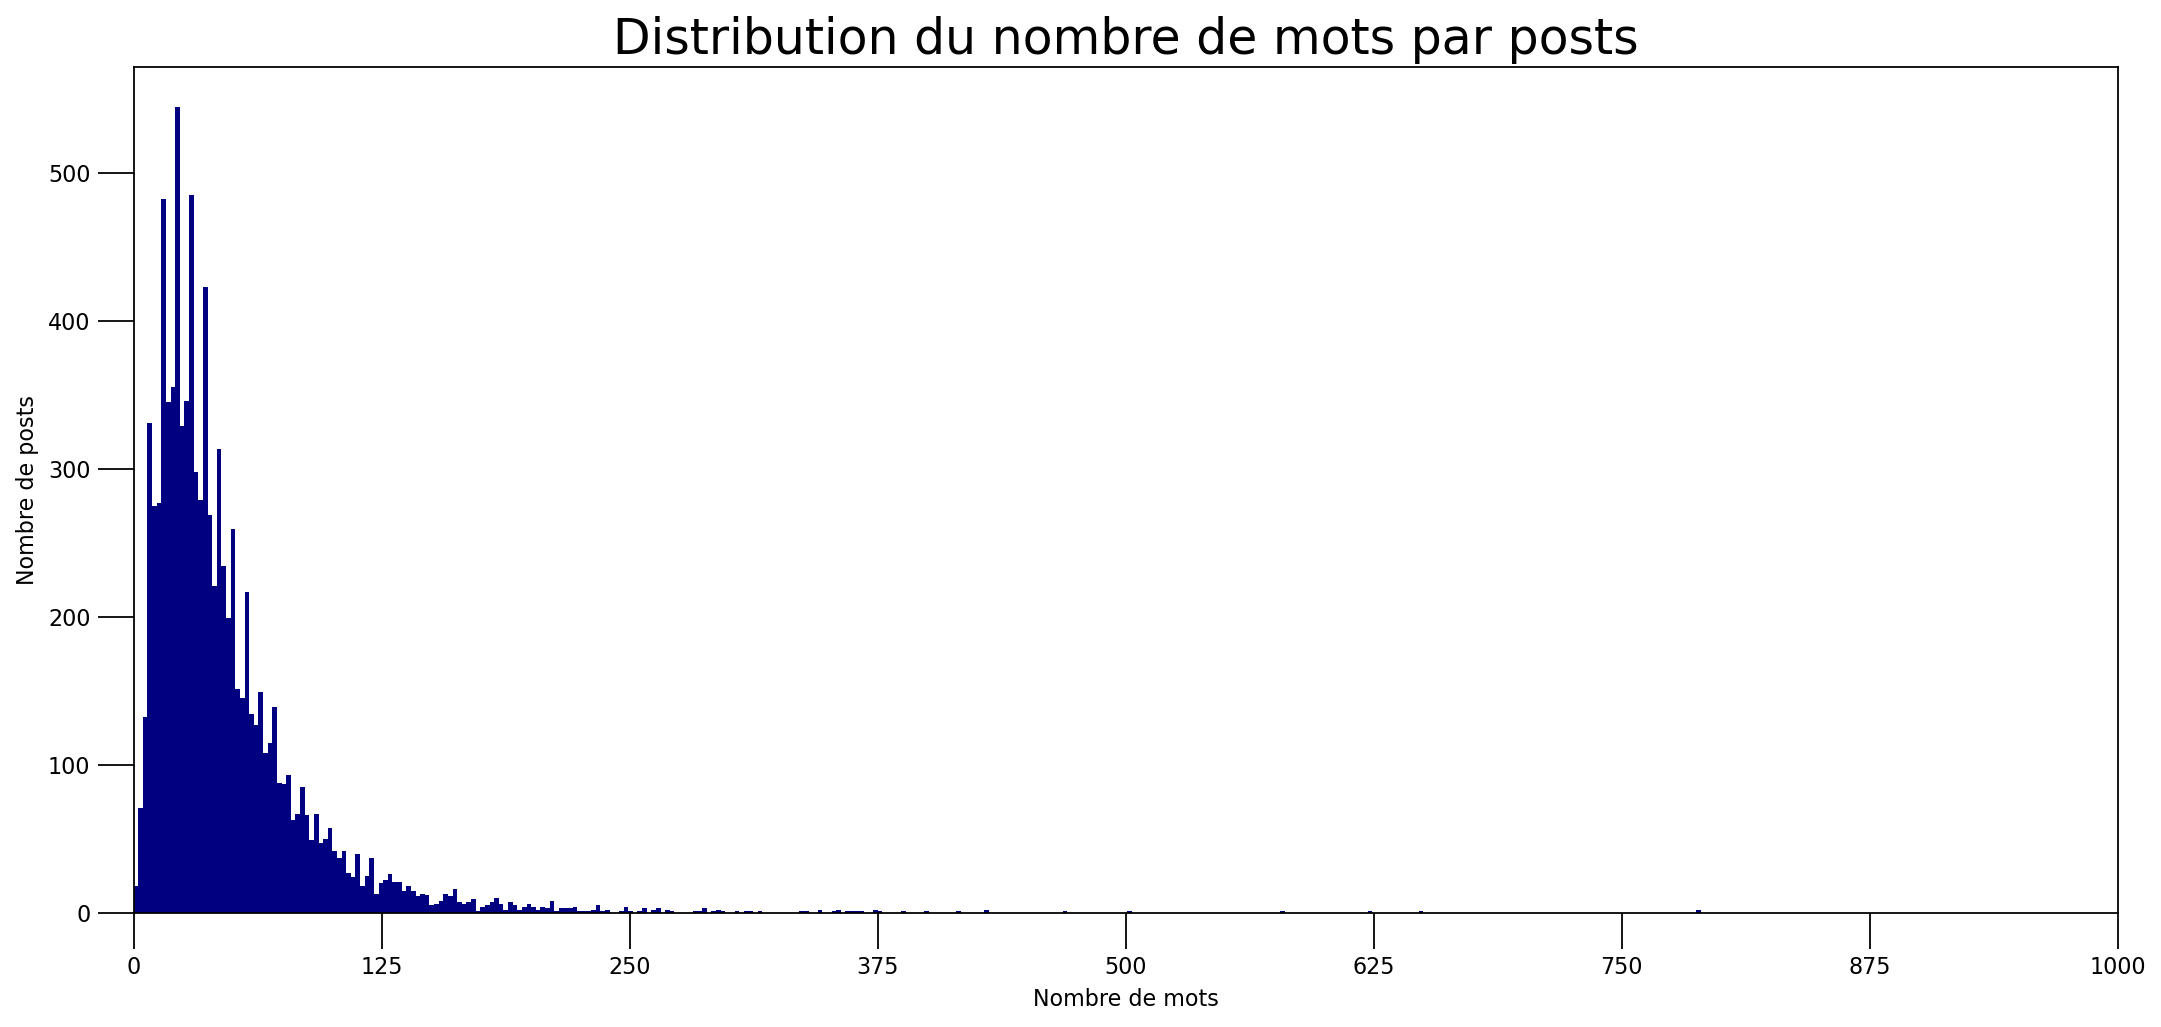

In [66]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
"""
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
"""
plt.gca().set(xlim=(0, 1000), ylabel='Nombre de posts', xlabel='Nombre de mots')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution du nombre de mots par posts', fontdict=dict(size=22))
plt.show()

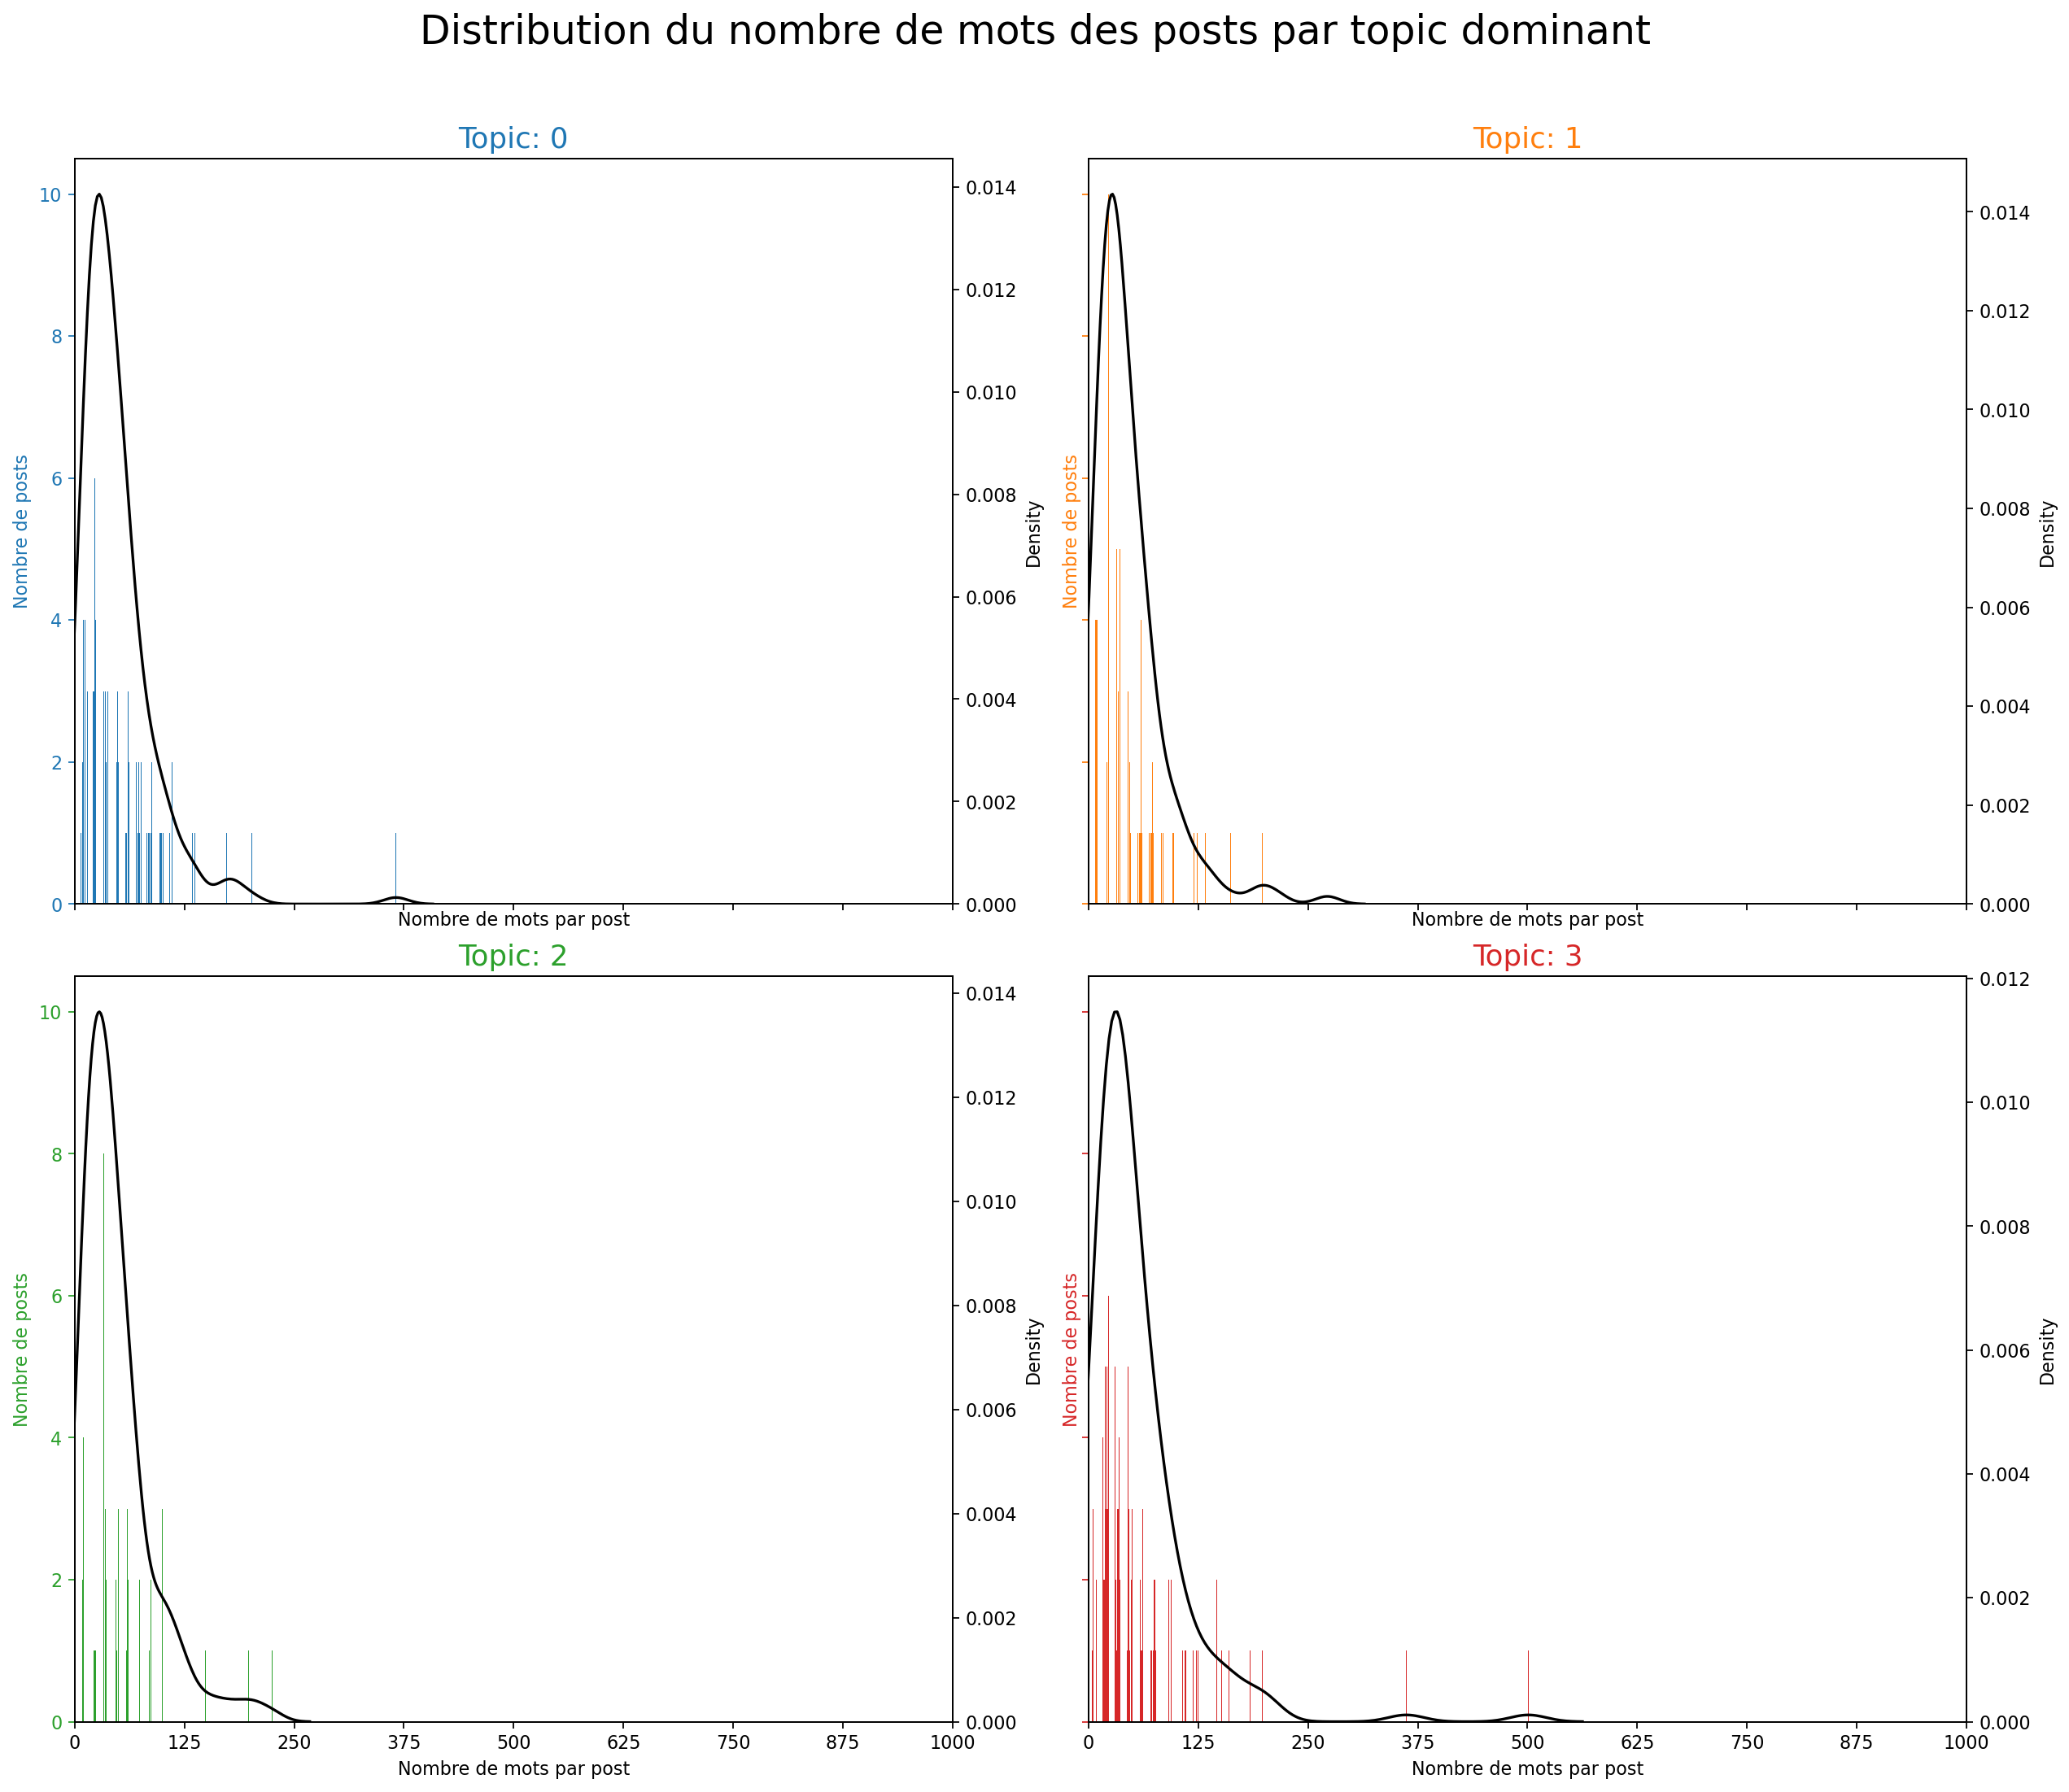

In [67]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Nombre de mots par post')
    ax.set_ylabel('Nombre de posts', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution du nombre de mots des posts par topic dominant', fontsize=22)
plt.show()

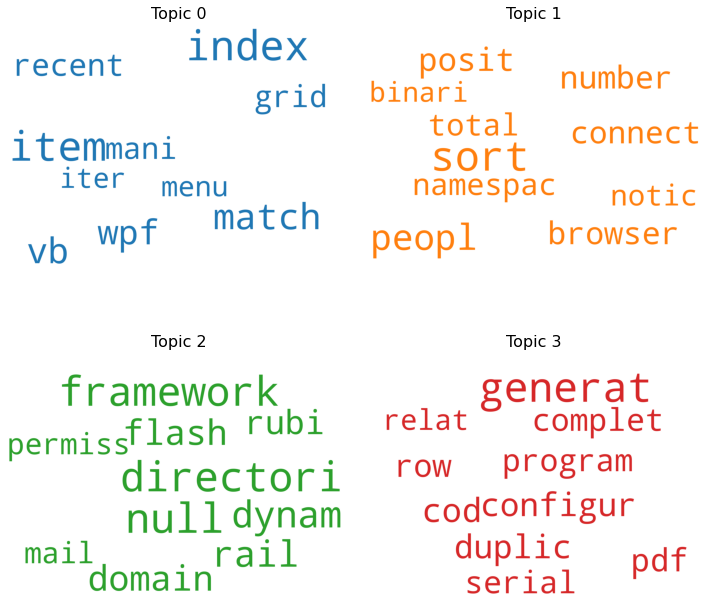

In [68]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf_optimized.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Nombre d'occurences d'un mot et poids dans les topics

On cherche à dégager les termes revenant souvent dans les topics dont la fréquence d'apparition est supérieure à leur poids dans le topic. 

Cela permet de montrer l'importance relative d'un terme dans le topic.

      word  topic_id  importance  word_count
0   folder        32    0.031293         454
1   receiv        32    0.024700         268
2      map        32    0.024045         444
3    build        32    0.021909         883
4   compon        32    0.020593         266
5    check        32    0.019834         768
6  handler        32    0.017560         188
7   machin        32    0.016919         394
8     form        32    0.015364        1102
9    integ        32    0.015356         159


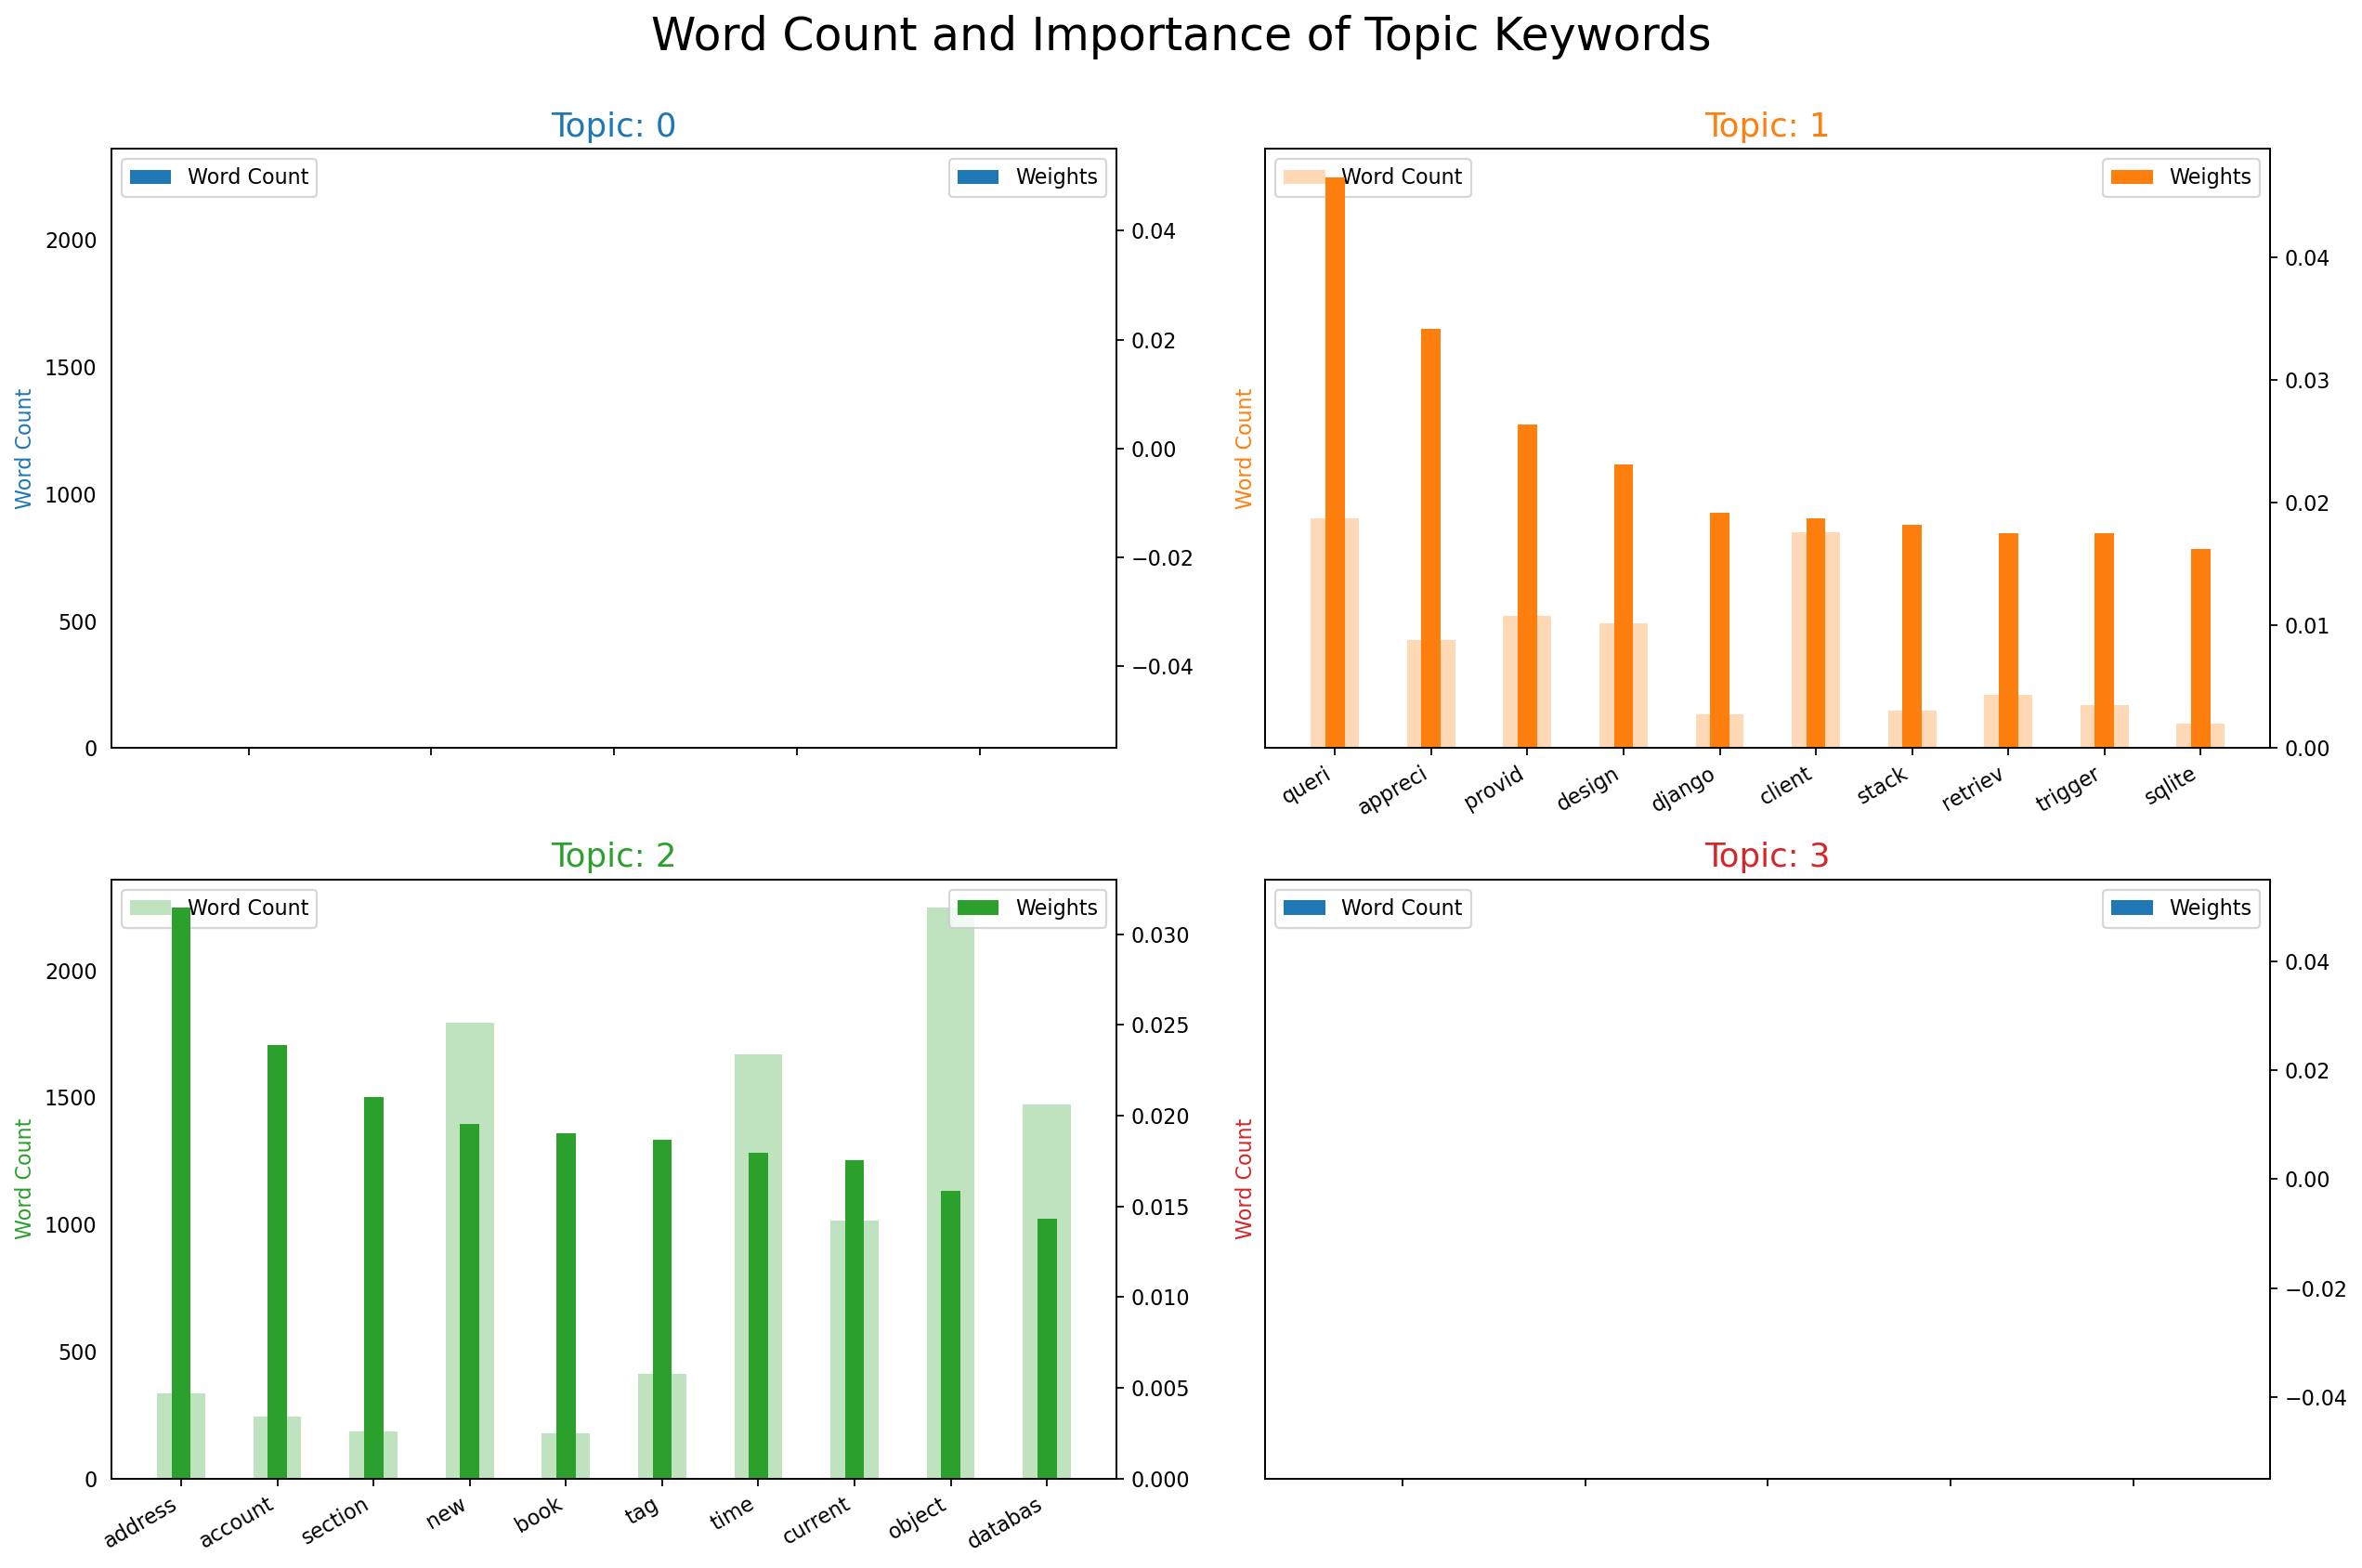

In [81]:

topics = lda_model_tfidf_optimized.show_topics(formatted=False)
data_flat = [w for w_list in processed_body for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

print(df.head(10))

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### Représentativité des topics

In [82]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(lda_model_tfidf_optimized, corpus_tfidf, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model_tfidf_optimized.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

On fait deux graphes: 
    
    Nombre de posts pour chaque topic auquel on assigne le post dans lequel il a le plus de poids 
    Nombre de topics pour chaque post où leur poids contribue significativement 

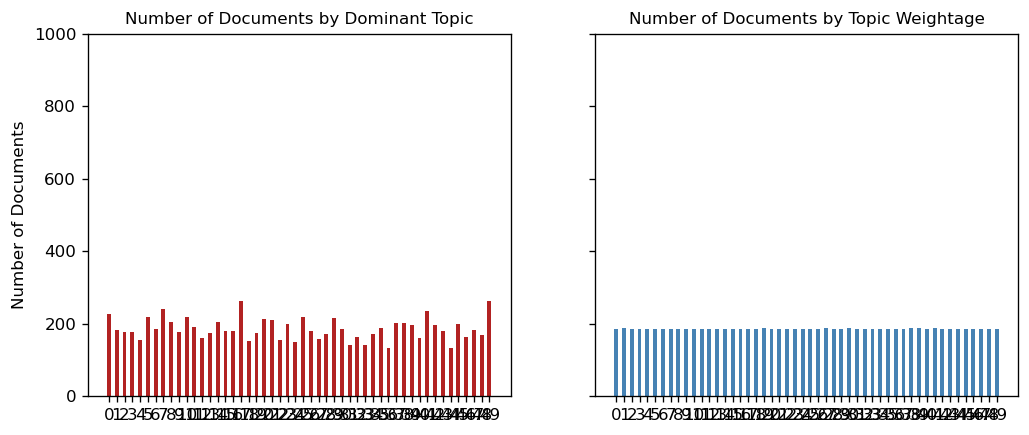

In [87]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
#tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
#ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 400)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
#ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

#### Représentation interactive des topics

In [89]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf_optimized, corpus_tfidf, dictionary=lda_model_tfidf_optimized.id2word,mds='tsne')
vis

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
19     -61.271099  -46.138103       1        1  2.011212
39       8.921947  107.212471       2        1  2.007121
38     -21.513622  -91.581131       3        1  2.006680
27     -16.955242  -47.279716       4        1  2.005649
1     -101.038155  -28.557734       5        1  2.005604
26     152.717316   39.462498       6        1  2.005102
3      -57.581432   35.482090       7        1  2.004677
30     123.289482  104.627472       8        1  2.004151
41     -31.626083 -141.693466       9        1  2.004137
40    -113.976891   20.259985      10        1  2.003105
17     143.387817  -96.872391      11        1  2.002928
49    -149.620300   35.249878      12        1  2.002849
31     -77.387878    2.783008      13        1  2.001996
28      26.019089 -164.202621      14        1  2.001874
44      34.373589  -42.274448      15        1  2.001675
7     -130.574783 -139.757614      16        1  2.001640
5       -6.827886  148.642639      17        1  2.001398
21       2.789268 -121.031929      18        1  2.001235
16     114.663597  -14.237005      19        1  2.001037
33    -108.380592   60.381638      20        1  2.001020
22      90.915436  -55.175823      21        1  2.000950
42      49.982967  193.584290      22        1  2.000703
12     -44.400032  -12.945228      23        1  2.000579
37     168.552582   -5.036569      24        1  2.000334
14     -84.593048 -131.925354      25        1  1.999993
47      73.992935   70.519897      26        1  1.999833
46      27.170315   -3.137258      27        1  1.999339
9     -105.585892  123.924393      28        1  1.999091
15     -52.915051  197.049133      29        1  1.998942
35      45.303410  132.109711      30        1  1.998792
32      -7.459244   61.939411      31        1  1.998617
23     106.251625   31.828230      32        1  1.998288
45      -2.575387  -10.684015      33        1  1.998177
36     -52.084110  132.451538      34        1  1.998155
10    -151.355591  -25.247257      35        1  1.998105
0     -164.171127  105.064507      36        1  1.998028
25      33.678108  -83.843285      37        1  1.997633
2       18.493750   32.310253      38        1  1.997551
8     -207.719315   11.388842      39        1  1.997507
48     -67.434219  -85.655739      40        1  1.997056
11     -67.634338   81.711128      41        1  1.997044
29      57.870335   38.369568      42        1  1.996583
20    -184.352325  -76.882454      43        1  1.995772
43      69.869698   -8.130033      44        1  1.995273
34      74.565353 -123.740829      45        1  1.995001
13     -33.369862   84.762848      46        1  1.994255
18      85.470840  131.323364      47        1  1.993929
24      32.549908   74.103302      48        1  1.993725
4      -22.989771   27.251673      49        1  1.993188
6     -116.732117  -73.864700      50        1  1.992465, topic_info=        Term       Freq       Total Category  logprob  loglift
600   thread  52.000000   52.000000  Default  30.0000  30.0000
334    array  48.000000   48.000000  Default  29.0000  29.0000
30    report  41.000000   41.000000  Default  28.0000  28.0000
22    option  46.000000   46.000000  Default  27.0000  27.0000
751    queri  61.000000   61.000000  Default  26.0000  26.0000
..       ...        ...         ...      ...      ...      ...
213  control   8.916381   82.701590  Topic50  -4.5040   1.6884
259     post   6.589588   36.690239  Topic50  -4.8064   2.1988
242   search   6.844854   47.224511  Topic50  -4.7684   1.9844
693     page   7.623206  100.178460  Topic50  -4.6607   1.3400
81    server   6.196684   94.021368  Topic50  -4.8678   1.1963

[2050 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
261      37  0.875624   abil
262       2  0.115278    abl
262       7  0.038426    abl
262       9  0.038426    abl
262      11  0.134491    

In [90]:
pyLDAvis.save_html(vis, 'lda.html')

#### Save model

In [91]:
lda_model_tfidf_optimized.save('./models/lda_model_tfidf_optimized')

#### Prédiction

In [3]:
lda = gensim.models.LdaMulticore.load('./models/lda_model_tfidf_optimized')

In [4]:
new_text = "Hello, I am developing a new application and I need to create a new table in sql-server database. " \
    "My application is an HTML form and I submit it through a javascript function. How can I do that ? Thanks !"
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stemmer = EnglishStemmer()
stemmed = ' '.join(stemmer.stem(WordNetLemmatizer().lemmatize(w, pos='v')) for w in w_tokenizer.tokenize(new_text))

pattern = re.compile('[^A-Za-z +]')
normalized = re.sub(pattern, ' ', stemmed)

result = []
#print(type(text))
for token in gensim.utils.simple_preprocess(normalized):
    if token not in gensim.parsing.preprocessing.STOPWORDS:
        result.append(token)
dictionary = []
dictionary.append(result)
from gensim.test.utils import common_corpus, common_dictionary        
other_corpus = [common_dictionary.doc2bow(text) for text in dictionary]

In [5]:
unseen_doc = other_corpus[0]
vector = lda[unseen_doc]

In [6]:
vector

([(0, 0.020000001),
  (1, 0.020000001),
  (2, 0.020000001),
  (3, 0.020000001),
  (4, 0.020000001),
  (5, 0.020000001),
  (6, 0.020000001),
  (7, 0.020000001),
  (8, 0.020000001),
  (9, 0.020000001),
  (10, 0.020000001),
  (11, 0.020000001),
  (12, 0.020000001),
  (13, 0.020000001),
  (14, 0.020000001),
  (15, 0.020000001),
  (16, 0.020000001),
  (17, 0.020000001),
  (18, 0.020000001),
  (19, 0.020000001),
  (20, 0.020000001),
  (21, 0.020000001),
  (22, 0.020000001),
  (23, 0.020000001),
  (24, 0.020000001),
  (25, 0.020000001),
  (26, 0.020000001),
  (27, 0.020000001),
  (28, 0.020000001),
  (29, 0.020000001),
  (30, 0.020000001),
  (31, 0.020000001),
  (32, 0.020000001),
  (33, 0.020000001),
  (34, 0.020000001),
  (35, 0.020000001),
  (36, 0.020000001),
  (37, 0.020000001),
  (38, 0.020000001),
  (39, 0.020000001),
  (40, 0.020000001),
  (41, 0.020000001),
  (42, 0.020000001),
  (43, 0.020000001),
  (44, 0.020000001),
  (45, 0.020000001),
  (46, 0.020000001),
  (47, 0.020000001),
  

In [ ]:
def find_topics(quest_iloc, df_topics_pred, topic_dict, freq_min=0.1):
    '''
    find & display topics about current question (indice loc to be specified)
    '''
    print("Cleaned question n°{}:".format(quest_iloc))
    print(token_dict[df_quest_cleaned.iloc[quest_iloc].name])
    print("\nTags : ", df_quest_cleaned.iloc[quest_iloc].Tags)
    print("")
    fig = plt.figure(figsize=(8, 6))
    df_topics_pred.iloc[quest_iloc].plot()
    #for topic_id_curr in np.nonzero(
    #    df_topics_pred.iloc[quest_iloc] > freq_min)[0]:
    list_topic_labels = df_topics_pred.\
        iloc[quest_iloc][df_topics_pred.iloc[quest_iloc] > freq_min].\
        sort_values(ascending=False).index
    print(list_topic_labels)
    list_topic_id =[]
    for label_curr in list_topic_labels:
        list_topic_id.append(int(re.findall(r"\d+", label_curr)[0]))
    print(list_topic_id)
    for topic_id_curr in list_topic_id:
        print("Topic {} : {}".format(topic_id_curr, 
                                     topic_dict[topic_id_curr]))
    return list(list_topic_id)

In [ ]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

In [3]:
pyLDAvis.disable_notebook()